<img src="header_profi.png" align="left"/>

# Exercise: Reinforcement Learning Moon Lander


The goal of this exercise is to work with reinforcement learning models and get a basic understanding of the topic. We will first develop controlers for the simple cart pole model and later for the lunar lander.
Neil Armstrong was the first to control a lunar lander in 1969. See a [video](https://youtu.be/xc1SzgGhMKc?t=520) about this masterpiece.
Luckily we do not have to go to the moon, but can do our experiments in simulation based on the [Openai gym](https://gym.openai.com/) software.


**Note**: openai gym is not well supported in anaconda. Please install gym in your conda environment using the following command:

```
pip install gym
pip install box2d box2d-kengz
```

**Note**: it can happend that the rendering window does not show up or close properly. In this case please check your environment and look for a solution and post it in the forum.


# Module imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import time

In [4]:
# suppress some warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [5]:
# GPU support
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2.0.0


# Very basic RL example

Run this basic cart pole example and find out how it works and what the basic functions of gym are. Document the code with python comments. Find out what the observation and action values mean.

In [7]:
#
# Result: documented code...
#
env = gym.make('CartPole-v0')
env.reset()
cumulated_reward = 0
for i in range(200):

    env.render(mode='close')
    
    action = env.action_space.sample()
    observation, reward, done, info = env.step( action )
    cumulated_reward += reward
    
    print( '\r', 'o:{} r:{} cr:{} d:{}   a:{}'.format(observation,reward,cumulated_reward,done,action), end='' )
    
    if done:
        env.reset()

    # some delay important for display to catch up
    time.sleep(0.1)
      
env.close()

 o:[-0.0136 -0.7319 -0.1029  0.6346] r:1.0 cr:200.0 d:False   a:0

# Implement a basic on-off control strategy

Before we go into advanced control strategies, lets attempt to control the cart pole with a simple on-off control strategy. Reading the [documentation](https://github.com/openai/gym/wiki/CartPole-v0) of this gym we find that it has two actions (push cart left = 0 and push cart right = 1). So, one idea could be to just look at the pole's angle and push the cart left if the pole leans to the left and vice versa. Give it a try.

In [10]:
env = gym.make('CartPole-v0')
env.reset()

cumulated_reward = 0
pole_angle = 0

for i in range(200):

    env.render(mode='close')
    
    # Result: implement your control strategy here
    if pole_angle < 0:
        action = 1
    else:
        action = 0

    observation, reward, done, info = env.step( action )
    cumulated_reward += reward
    pole_angle = observation[0]

        
    print( '\r', 'a:{:.2f} p:{:.2f} r:{} cr:{} d:{}   a:{}'.format(observation[2],observation[0],reward,cumulated_reward,done,action), end='' )
    
    if done:
        env.reset()
        cululated_reward = 0

    # some delay important for display to catch up
    time.sleep(0.1)
      
env.close()

 a:-0.07 p:0.04 r:1.0 cr:200.0 d:False   a:01:0.14 p:-0.17 r:1.0 cr:51.0 d:False   a:1a:-0.04 p:0.02 r:1.0 cr:199.0 d:False   a:1

# DQN Solution to cart pole balancing

Now lets build a first version based on advanced RL technique, the Deep Q-Network. Here a neural network is trained to estimate the best action for a state based on the Q-learning concept.

The code is based on the work by Greg Surma and it can be found [here](https://github.com/gsurma/cartpole).

Please go through the code and answer the questions in the comments of the code (marked by Task). 

**Note**: Place your answer as comment below the questions.

In [ ]:
import numpy as np
import random
import pandas as pd

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import model_from_json
import gym

prefix = 'results/16_dqn_'

# hyperparameters from https://towardsdatascience.com/ai-learning-to-land-a-rocket-reinforcement-learning-84d61f97d055

GAMMA = 0.99
LEARNING_RATE = 0.001
LEARNING_RATE_DECAY = 0.0001
MEMORY_SIZE = 1000000
BATCH_SIZE = 20
EXPLORATION_MAX = 0.75
EXPLORATION_MIN = 0.1
EXPLORATION_DECAY = 0.995

class DQNControl:

    def __init__(self, observation_space, action_space,layout=[24,24],name='nona'):
        
        print ('building DQN model with observation space {} and action space {} layer {} name {}'.format(observation_space, action_space,layout,name) )
        
        self.exploration_rate = EXPLORATION_MAX
        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.name = name
        
        self.model = Sequential()
        self.model.add(Dense(layout[0], input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(layout[1], activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE,decay=LEARNING_RATE_DECAY ))

        
    def save(self):
        modelName = prefix + self.name + "model.json"
        weightName = prefix + self.name + "model.h5"
        model_json = self.model.to_json()
        with open( modelName , "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.model.save_weights( weightName )
        print("saved model to disk as {} {}".format(modelName,weightName))

        
    def load(self):    
        modelName = prefix + self.name + "model.json"
        weightName = prefix + self.name + "model.h5"
        json_file = open(modelName, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        self.model.load_weights(weightName)
        print("loaded model from disk")
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    def action(self,state):
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])
        
        
        
    def act(self, state):
        #
        # Task: what is the purpose of this if statement
        # Result: ....
        #
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)

        q_values = self.model.predict(state)
        
        #
        # Task: what is the idea behind this step (to come from value to action)?
        # Result: ....
        #
        return np.argmax(q_values[0])

    
    def experience_replay(self):
        
        if len(self.memory) < BATCH_SIZE:
            return
        
        batch = random.sample(self.memory, BATCH_SIZE)
        
        for state, action, reward, state_next, done in batch:
            
            q_update = reward
            if not done:
                #
                # Task: give an explanation for the formula of the update of the Q-value
                # Result: ...
                #
                q_update = (reward + GAMMA * np.amax( self.model.predict(state_next)[0] ) )
            
            q_values = self.model.predict(state)
            
            q_values[0][action] = q_update
            
            self.model.fit(state, q_values, verbose=0)
            
            
            
    def close_episode(self):
        #
        # Task: what is going on here?
        # Result: ...
        #
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)          

In [12]:
def trainDQN(env,episodes=50,layout=[24,24], name='nona', termination_reward=None, termination_runs=None, termination_runs_reward=None ):
    
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n

    dqn_solver = DQNControl(observation_space, action_space,layout,name)
    
    history = []
    run = 0
    
    accumulated_reward = 0
    sliding_accumulated_reward = 0
    
    while run < episodes:
        
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        while True:
            
            step += 1
            
            env.render(mode='close')
            
            action = dqn_solver.act(state)
            
            state_next, reward, terminal, info = env.step(action)
            
            accumulated_reward += reward
            
            if not (termination_runs is None) and step > termination_runs:
                terminal = True
                if not (termination_runs_reward is None):
                    reward = termination_runs_reward
            else:
                if terminal and not (termination_reward is None):
                    reward = termination_reward
            
            state_next = np.reshape(state_next, [1, observation_space])
            
            dqn_solver.remember(state, action, reward, state_next, terminal)
            
            state = state_next
            
            if terminal:
                
                sliding_accumulated_reward = sliding_accumulated_reward * 0.9 + accumulated_reward * 0.1
                
                print ( '\r', 'episode: {}, exploration: {:.3f}, score: {} sliding score {}'.format(run,dqn_solver.exploration_rate,accumulated_reward,sliding_accumulated_reward), end='' )
                
                history.append([run,dqn_solver.exploration_rate,accumulated_reward,sliding_accumulated_reward,step])
                
                accumulated_reward = 0
                break
            
            dqn_solver.experience_replay()
        
        
        dqn_solver.close_episode()
        
        
        run += 1

    env.close()
    return dqn_solver,history

Using TensorFlow backend.


In [ ]:
env = gym.make("CartPole-v1")
control,history = trainDQN(env=env,episodes=60,layout=[24,24],name='cartdqn',termination_reward=-200,termination_runs=100,termination_runs_reward=None)

In [ ]:
# Save model for later
control.save()

In [ ]:
df = pd.DataFrame(history)

In [ ]:
df[1].plot()

In [ ]:
df[2].plot()
df[3].plot()

In [ ]:
# Test the DQL control

In [13]:
env = gym.make('CartPole-v1')

env.reset()

observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
control = DQNControl(observation_space, action_space, name='cartdqn')
control.load()

state = env.reset()
cumulated_reward = 0

for i in range(100):
    env.render(mode='close')

    # Result: implement your control strategy here
    action = control.action( np.reshape(state, [1, observation_space]) )
    observation, reward, done, _ = env.step( action )
    
    cumulated_reward += reward
        
    print( '\r', 'a:{:.2f} p:{:.2f} r:{} cr:{} d:{}   a:{}'.format(observation[2],observation[0],reward,cumulated_reward,done,action), end='' )
    
    if done:
        state = env.reset()
        cumulated_reward = 0

    # some delay important for display to catch up
    time.sleep(0.05)
      
env.close()

building DQN model with observation space 4 and action space 2 layer [24, 24] name cartdqn
loaded model from disk
 a:-0.02 p:0.06 r:1.0 cr:3.0 d:False   a:11

# Actor critic model

Implement the actor critic model [1] for the cart pole gym. Lookup some tutorials and implement it in a similar structure as DQNControll. Compare the results.

- [1] https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf


In [ ]:
#
# Result: actor critic solution for cart
#

In [ ]:
# source: https://github.com/rlcode/reinforcement-learning/blob/master/2-cartpole/4-actor-critic/cartpole_a2c.py


import sys
import gym
import pylab
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

prefix = 'results/16_ac_'


class ACControl:
    
    def __init__(self, state_size, action_size):
        
        # if you want to see Cartpole learning, then change to True
        self.render = True
        
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.95
        self.actor_lr = 0.005
        self.critic_lr = 0.001

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()


            
    def save(self):
        
        modelName = prefix + "amodel.json"
        weightName = prefix + "amodel.h5"
        
        model_json = self.actor.to_json()
        with open( modelName , "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.actor.save_weights( weightName )

        
        modelName = prefix + "cmodel.json"
        weightName = prefix + "cmodel.h5"
        
        model_json = self.critic.to_json()
        with open( modelName , "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.critic.save_weights( weightName )
        
        print("saved a and c model to disk with prefix {}".format(prefix))

        
    def load(self):    
        
        modelName = prefix + "amodel.json"
        weightName = prefix + "amodel.h5"
        
        json_file = open(modelName, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.amodel = model_from_json(loaded_model_json)
        self.amodel.load_weights(weightName)
        
        
        modelName = prefix + "cmodel.json"
        weightName = prefix + "cmodel.h5"
        
        json_file = open(modelName, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.cmodel = model_from_json(loaded_model_json)
        self.cmodel.load_weights(weightName)
        
        print("loaded model from disk")
            
            
            
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        #actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    
    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        #critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    
    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]

    
    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
    
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

        

def trainACModel(episodes=500):        
    
    env = gym.make('CartPole-v1')
    
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = ACControl(state_size, action_size)

    scores = []
    history = []
    
    for e in range(episodes):
        
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        duration = 0
        while not done:
            if agent.render:
                env.render(mode='close')

            action = agent.get_action(state)
            
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            agent.train_model(state, action, reward, next_state, done)

            score += reward
            state = next_state
            duration += 1

            if done:
                score = score if score == 500.0 else score + 100
                scores.append(score)

                print ( '\r', 'episode: {}, exploration: {:.3f}, score: {}'.format(e, 0.5, duration), end='' )
                
                history.append([e,0.5,duration])
                
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    sys.exit()
                    
    return agent,history


In [ ]:
accontrol, history = trainACModel(episodes=300)

In [ ]:
accontrol.save()

In [ ]:
df = pd.DataFrame(history)

In [ ]:
#
# Plot scores
#
df[2].plot()

# Lunar lander problem

How we are looking into the lunar lander problem. We reuse the DQN controller from above with different parameters. Play with this problem and get an understanding of the rewards. Configuration is taken from [2]. A general discussion about this approach was published in [1].

- [1] https://www.researchgate.net/publication/333145451_Deep_Q-Learning_on_Lunar_Lander_Game
- [2] https://towardsdatascience.com/ai-learning-to-land-a-rocket-reinforcement-learning-84d61f97d055

In [14]:
env = gym.make('LunarLander-v2')
control,history = trainDQN(env=env,episodes=150,layout=[64,32],name='lunar',termination_reward=None,termination_runs=150,termination_runs_reward=-200)

building DQN model with observation space 8 and action space 4 layer [64, 32] name lunar
 episode: 112, exploration: 0.428, score: 16.222945166060736 sliding score 1.029224324186520417

KeyboardInterrupt: 

In [6]:
# Save model for later
control.save()

saved model to disk as results/04_dqn_lunarmodel.json results/04_dqn_lunarmodel.h5


In [7]:
df = pd.DataFrame(history)

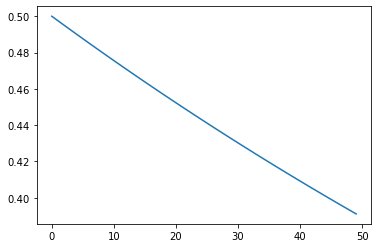

In [8]:
df[1].plot()

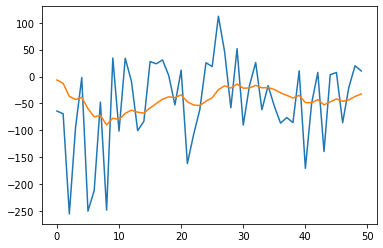

In [9]:
df[2].plot()
df[3].plot()

# Implement an improved controler for the lunar lander

Search the internet for leadboards for lunar lander and try to implement one of the best solutions. Select your solution by simplicity and clarity of code. Comment the code.

In [ ]:
#
# Result: implementation of improved controler
#
